In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.cca_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
from src.utils import *
import pickle
import scipy as sio
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import os
from itertools import cycle, islice

import copy

# pathdump:

N5 
cp1_path = '/home/diya/Documents/rat-fes/data/filipe_data/N5/N5_170929_No Obstacles_s.mat'
cp2_path = '/home/diya/Documents/rat-fes/data/filipe_data/N5/N5_171001_No Obstacles_s.mat'
'N5_171016_No Obstacles_s.mat'
'N5_171130_No Obstacles_s.mat'

n6
'N6_171026_No Obstacles_s.mat' this day has pretty low %vaf max
'N6_171204_No Obstacles_s.mat'
'N6_171211_No Obstacles_s.mat'

n9
cp1_path = '/home/diya/Documents/rat-fes/data/filipe_data/N9/N9_171121_No Obstacles_s.mat'
cp2_path = '/home/diya/Documents/rat-fes/data/filipe_data/N9/N9_171204_No Obstacles_s.mat'
'N9_171211_No Obstacles_s.mat'  'N9_171214_No Obstacles_s.mat

In [2]:
cp1_path = '/home/diya/Documents/rat-fes/data/filipe_data/N9/N9_171121_No Obstacles_s.mat'

cp2_path = '/home/diya/Documents/rat-fes/data/filipe_data/N9/N9_171204_No Obstacles_s.mat'

cp1 = CortProcessor(cp1_path)
cp2 = CortProcessor(cp2_path)

this is filipe data i belive
this is filipe data i belive


In [3]:
subsample_list = [0.005, 0.01, 0.1, 0.5, 1.0]
nummy = cp2.data['rates'][0].shape[0]

In [4]:
#get day0 decoder weights, scaled + unscaled versions
lowest_num_dimensions=8

day0_decoder, nada, naday, nadax = cp1.decode_angles(X=cp1.apply_PCA(dims=lowest_num_dimensions))
#lowest_num_dimensions = cp1.num_components
print(np.average(nada, 1)[1])

X_tempy =cp1.apply_PCA(lowest_num_dimensions)
scaler = StandardScaler()
X_scale = scaler.fit_transform(np.squeeze(X_tempy))
day0_decoder_scale, nada, naday, nadax = cp1.decode_angles(X=[X_scale])

print(np.average(nada, 1)[1])

0.43100000000000005
0.433


In [5]:
fixed_decoder_scores = []
pca_decoder_scores = []
pca_predic=[]
number_of_gaits=[]

for i in range(len(subsample_list)):
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    gait_counter = sub_y
    temp_gaits, nada = cp2.get_gait_indices(Y=sub_y)
    number_of_gaits.append(temp_gaits[0].size - 1)
    #apply PCA just using subsampled data
    sub_x_pca = cp2.apply_PCA(dims=lowest_num_dimensions, X=sub_x)
    #save PCA transformation
    pca_object = cp2.pca_object
    #train PCA decoder 
    temp_h, nada, nadax, naday = cp2.decode_angles(X=sub_x_pca, Y=sub_y)
    
    test_x = np.squeeze(np.array(cp2.apply_PCA(dims=lowest_num_dimensions, transformer = pca_object)))
    test_y = np.squeeze(np.array(cp2.data['angles']))
    
    test_x_format, test_y_format = format_data(test_x, test_y)
    
    temp_y = test_wiener_filter(test_x_format, day0_decoder)
    fixed_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    
    temp_y = test_wiener_filter(test_x_format, temp_h)
    pca_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    
    pca_predic.append(temp_y)

print(fixed_decoder_scores)
print(pca_decoder_scores)

(38,)
(75,)
(750,)
(3750,)
(7500,)
[-0.64, -1.15, -0.51, -0.49, -0.58]
[-47086.59, -239.1, 0.24, 0.56, 0.57]


In [6]:
cca_decoder_scores = []
cca_transformers=[]
for i in range(len(subsample_list)):
    #make subsampled cp2
    temp_cp2 = copy.deepcopy(cp2)
    sub_x2, sub_y2 = temp_cp2.subsample(percent = subsample_list[i])
    
    temp_cp2.data['rates'] = sub_x2
    temp_cp2.data['angles'] = sub_y2
    
    temp_cca = CCAProcessor(cp1, temp_cp2)
    
    pca_sub_x1, pca_sub_x2 = temp_cca.apply_PCA(preset_num_components=lowest_num_dimensions)
    temp_cca_transformer, nada = temp_cca.apply_CCA(preset_num_components = lowest_num_dimensions, pca=True)
    
    cca_transformers.append(temp_cca_transformer)
    
    test_x = np.squeeze(np.array(cp2.apply_PCA(dims=lowest_num_dimensions, transformer = temp_cca.data['cp2']['pca_transformer'])))
    test_y = np.squeeze(np.array(cp2.data['angles']))
    
    nada, test_x_cca_space = temp_cca_transformer.transform(test_x, test_x)
    
    temp_x = temp_cca_transformer.inverse_transform(test_x_cca_space)
    
    temp_x_format, test_y_format = format_data(temp_x, test_y)
    predic = test_wiener_filter(temp_x_format, day0_decoder)
    
    cca_decoder_scores.append(vaf(test_y_format[:,1], predic[:,1]))

(12015,)
(38,)
should be good to align
(35, 25)
(35, 5)
(35, 31)
(35, 5)
dim0 corr is 0.82
dim1 corr is 0.78
dim2 corr is 0.76
(12015,)
(75,)
should be good to align
(52, 25)
(52, 5)
(52, 31)
(52, 5)
dim0 corr is 0.77
dim1 corr is 0.67
dim2 corr is 0.63
(12015,)
(750,)
should be good to align
(608, 25)
(608, 5)
(608, 31)
(608, 5)
dim0 corr is 0.57
dim1 corr is 0.49
dim2 corr is 0.29
(12015,)
(3750,)
should be good to align
(3181, 25)
(3181, 5)
(3181, 31)
(3181, 5)
dim0 corr is 0.48
dim1 corr is 0.44
dim2 corr is 0.28
(12015,)
(7500,)
should be good to align
(6055, 25)
(6055, 5)
(6055, 31)
(6055, 5)
dim0 corr is 0.47
dim1 corr is 0.44
dim2 corr is 0.26


In [7]:
r_scores = []
r_predic=[]
pinv_scores=[]
pinv_predic_all = []
day0_decoder_no_offset = day0_decoder[1:,:]
offset = day0_decoder[0,:]

for i in range(len(subsample_list)):
    #subsample day-n unprocessed data
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    pinv_clf = temp_cca.apply_pinv_transform(x=sub_x[0], y=sub_y[0], decoder=day0_decoder) 
    #apply PCA to subsampled data
    sub_x_pca = np.squeeze(cp2.apply_PCA(dims=lowest_num_dimensions, X=sub_x))
    #transform PCA subsample to day-0 shape
    nada, sub_x_cca_space = cca_transformers[i].transform(sub_x_pca, sub_x_pca)
    temp_x = cca_transformers[i].inverse_transform(sub_x_cca_space)
    #scale transformed data 
    scaler = StandardScaler()
    temp_x_scale = scaler.fit_transform(temp_x)
    
    temp_x_format, temp_y_format = format_data(temp_x_scale, sub_y[0])
    wpost, nada = ridge_fit(b0=day0_decoder_scale, x_format = temp_x_format, y_format = temp_y_format, my_alpha=100.0)
    
    
    ###now lets test on full dataset
    test_x = np.squeeze(np.array(cp2.apply_PCA(dims=lowest_num_dimensions, transformer = cp2.pca_object)))
    test_y = np.squeeze(np.array(cp2.data['angles']))
    
    raw_test_x = cp2.data['rates'][0]
    raw_test_y = cp2.data['angles'][0]
    
    raw_test_x_format, raw_test_y_format = format_data(raw_test_x, raw_test_y)
    trans_test_x = pinv_clf.predict(raw_test_x_format)
    pinv_predict = np.dot(trans_test_x, day0_decoder_no_offset) + offset
    
    pinv_predic_all.append(pinv_predict)
    
    nada, test_xx = temp_cca.apply_CCA(cp2_x = test_x, transformer = cca_transformers[i])
    test_xx_scale = scaler.transform(test_xx)
    test_xx_scale_format, nada = format_data(test_xx_scale, test_y)
    temp_y = test_wiener_filter(test_xx_scale_format, wpost)
    
    r_predic.append(temp_y)  
    predic = vaf(test_y_format[:,1], temp_y[:,1])
    pinv_scores.append(vaf(test_y_format[:,1], pinv_predict[:,1]))
    
 
    r_scores.append(predic)

initial_scoring is : -0.77
new_scoring is: 0.63
dim0 corr is 0.47
dim1 corr is -0.38
dim2 corr is -0.53
initial_scoring is : -0.16
new_scoring is: 0.7
dim0 corr is 0.04
dim1 corr is -0.26
dim2 corr is 0.14
initial_scoring is : 0.01
new_scoring is: 0.44
dim0 corr is -0.76
dim1 corr is -0.64
dim2 corr is -0.63
initial_scoring is : 0.11
new_scoring is: 0.53
dim0 corr is -0.03
dim1 corr is -0.02
dim2 corr is 0.32
initial_scoring is : -0.62
new_scoring is: 0.57
dim0 corr is 0.17
dim1 corr is -0.09
dim2 corr is -0.12


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
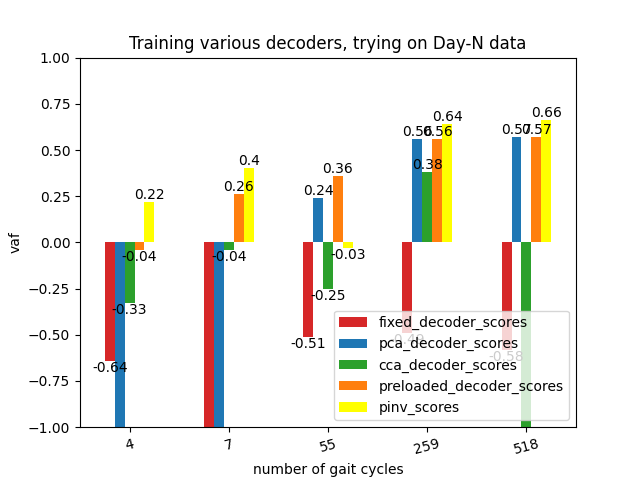

In [8]:
%matplotlib widget
%matplotlib widget

plot_dict = {}
plot_dict['fixed_decoder_scores'] = fixed_decoder_scores
plot_dict['pca_decoder_scores'] = pca_decoder_scores
plot_dict['cca_decoder_scores'] = cca_decoder_scores
plot_dict['preloaded_decoder_scores'] = r_scores
plot_dict['pinv_scores'] = pinv_scores

index = number_of_gaits

df = pd.DataFrame(data=plot_dict, index=index)

my_colors = list(islice(cycle(['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow', 'k']), None, len(df)))

  
# plot grouped bar chart
ax = df.plot.bar(rot=15, color=my_colors)
ax.set_ylim(bottom=-1, top=1)
ax.set_title('Training various decoders, trying on Day-N data')
ax.set_ylabel('vaf')
ax.set_xlabel('number of gait cycles')
ax.legend(loc='lower right')
for container in ax.containers:
    diya = ax.bar_label(container)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
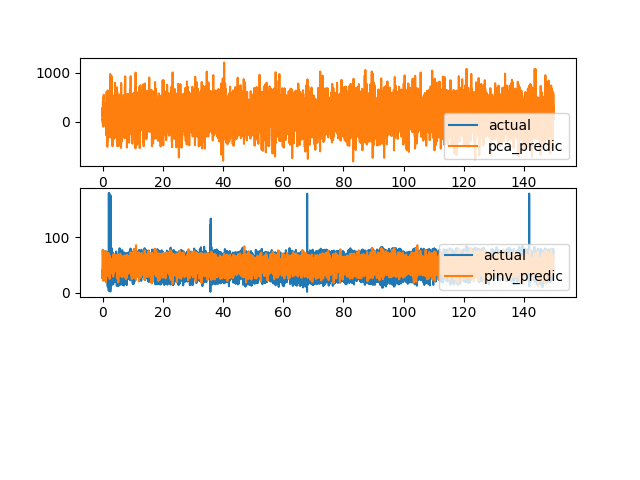

In [9]:
fig0 = plt.figure()
ax0 = fig0.add_subplot(311)
ts = np.arange(0, test_y_format.shape[0]/50, 1/50)

num = 1 

legend1=['actual', 'pca_predic']
legend2=['actual','pinv_predic']


ax0.plot(ts, test_y_format[:,1])
ax0.plot(ts, pca_predic[num][:,1])
ax0.legend(legend1, loc='lower right')

ax01 = fig0.add_subplot(312, sharex=ax0)
ax01.plot(ts, test_y_format[:,1])
ax01.plot(ts, pinv_predic_all[num][:,1])
ax01.legend(legend2, loc='lower right')


# questions
1) when to "format" data into folds?
2) no alignment necesssary, right?
3) little hetereogenous with how it changes with data
